In [1]:
# Import libraries and set desired options

from __future__ import division, print_function
# Disable Anaconda warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.decomposition import FastICA, TruncatedSVD

from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances, manhattan_distances

In [2]:
# A helper function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [3]:
def analyze_results(cv_res):
    import re 
    
    results = pd.DataFrame(cv_res['params'])
    results['mean_score'] = cv_res['mean_test_score']
    results['std_score'] = cv_res['std_test_score']
    results['rank'] = cv_res['rank_test_score']
#     results = results.sort_values('rank')
    
    n_splits = len(cv_res['split0_test_score'])
    cv_results = np.r_[[clf.cv_results_[k] for k in clf.cv_results_.keys() if re.match(r'split\d+_test', k)]]
    cv_results = pd.DataFrame(cv_results)
    melted = cv_results.melt()
    melted['split_num'] = list(range(cv_results.shape[0])) * cv_results.shape[1]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), gridspec_kw={'width_ratios':[2, 1]})
    
    sns.barplot(x='split_num', y='value', hue='variable', data=melted, ax=axes[0, 0]);
    axes[0, 0].set_ylim(melted['value'].min()-.01, 1);
    
    sns.violinplot(x='variable', y='value', hue='variable', data=cv_results.melt(), ax=axes[0, 1], dodge=False);
    sns.boxplot(x='variable', y='value', data=melted, ax=axes[1, 0]);
    sns.barplot(x=results.index, y='std_score', data=results, ax=axes[1, 1]);
    
    sns.despine()
    return results, cv_results

## Load data

In [4]:
# Load websites dictionary
with open(r"data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])

print(u'Websites total:', sites_dict.shape[0])

Websites total: 48371


In [5]:
df_users = pd.read_csv('data/data_users.csv', index_col=0)
df_users.head(3)

,data,user
0,270 270 270 21 21 7832 21 7832 30 7832 29 7832...,Alice_log
1,63 66 53 52 49 52 21 196 52 197 52 55 56 55 58...,user2227
2,1 63 167 23 21 23 22 812 22 676 39 21 21 679 2...,user1666


In [6]:
df_alice = pd.read_csv('data/Alice_log.csv')
df_alice['site'] = df_alice['site'].map(sites_dict.reset_index().set_index('site').iloc[:, 0])

top_sites = dict()
for i in [5, 10, 25, 50, 100, 250, 500, 1000]:
    top_sites['top'+str(i)] = df_alice['site'].value_counts()[:i].index

In [66]:
# Read the training and test data sets
train_df = pd.read_csv('data/train_sessions.csv',
                       index_col='session_id')
# train_df = pd.read_csv('data/data_full.csv', index_col=0)
# train_df = train_df.drop(['for_folds', 'user'], axis=1)

test_df = pd.read_csv('data/test_sessions.csv',
                      index_col='session_id')

In [67]:
# Switch time1, ..., time10 columns to datetime type
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

In [68]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Dataframe with indices of visited websites in session
full_sites = full_df[sites]

# Index to split the training and test data sets
idx_split = train_df.shape[0]

### get time features

In [69]:
def get_time_features(df):
    time_df = pd.DataFrame(index=df.index)
    
#     hour = df['time1'].apply(lambda ts: ts.hour)
#     time_df['orig_spl0'] = ((hour >= 7) & (hour <= 11)).astype('int')
#     time_df['orig_spl1'] = ((hour >= 12) & (hour <= 18)).astype('int')
#     time_df['orig_spl2'] = ((hour >= 19) & (hour <= 23)).astype('int')

#     month = df['time1'].dt.month
#     month[month<=2] = month[month<=2] + 12
#     cutted = pd.cut(month, bins=[0, 5, 8, 11, 100], labels=[str(num) for num in range(4)])
#     month_dum = pd.get_dummies(cutted, prefix='month', prefix_sep='')
#     time_df = pd.concat([time_df, month_dum], axis=1)
    
    
    
    time_df['total_months'] = (df['time1'].dt.year - df['time1'].dt.year.min()) * 12 + df['time1'].dt.month
    time_df['minutes'] = df['time1'].dt.hour * 60 + df['time1'].dt.minute
    time_df['minutes_sin'] = np.sin(2*np.pi*time_df['minutes']/1440.)
    time_df['minutes_cos'] = np.cos(2*np.pi*time_df['minutes']/1440.)
         
    for bins_spl in [[-1, 720, 1140, 100000]]:
        cutted = pd.cut(time_df['minutes'], bins=bins_spl, labels=[str(num)+'b' for num in range(len(bins_spl)-1)])
        hours_dum = pd.get_dummies(cutted, prefix=str(len(bins_spl))+'_spl', prefix_sep='')
        time_df = pd.concat([time_df, hours_dum], axis=1)

    time_df['dow'] = df['time1'].apply(lambda ts: ts.date().weekday())
    dtimes = ['dt'+str(i) for i in range(2, 11)]
    for i in range(2, 11):
        time_df['dt'+str(i)] = (df['time'+str(i)] - df['time'+str(i-1)]).astype('timedelta64[s]')
    time_df['dt'] = time_df[dtimes].mean(axis=1).fillna(0)#.apply(np.log1p)
    time_df['dt_std'] = time_df[dtimes].std(axis=1).fillna(0)#.apply(np.log1p)
    
    time_df = pd.concat([time_df, pd.get_dummies(df['time1'].dt.hour, prefix='h')], axis=1)
    time_df = pd.concat([time_df, pd.get_dummies(time_df['dow'], prefix='dow')], axis=1)
    
    time_df['h_12_13'] = time_df['h_12'] | time_df['h_13']
    time_df['h_16_17_18'] = time_df['h_16'] | time_df['h_17'] | time_df['h_18']
    time_df['h_not'] = ~(time_df['h_12_13'] | time_df['h_16_17_18'])
    
    time_df['dow_0_1'] = time_df['dow_0'] | time_df['dow_1']
    time_df['dow_2_3_4'] = time_df['dow_2'] | time_df['dow_3'] | time_df['dow_4']
    time_df['dow_5_6'] = time_df['dow_5'] | time_df['dow_6']
    time_df['dow_not'] = ~time_df['dow_0_1']
    
    for i in range(2, 11):
        del time_df['dt'+str(i)]

    return time_df

In [70]:
full_time = get_time_features(full_df[times])
ft_columns = full_time.columns

# hours_dum = pd.get_dummies(pd.cut(full_time['hour'], bins=4, labels=['1', '2', '3', '4']), prefix='spl', prefix_sep='')
# full_time = pd.concat([full_time, hours_dum], axis=1)
print(ft_columns)

Index(['total_months', 'minutes', 'minutes_sin', 'minutes_cos', '4_spl0b',
       '4_spl1b', '4_spl2b', 'dow', 'dt', 'dt_std', 'h_7', 'h_8', 'h_9',
       'h_10', 'h_11', 'h_12', 'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18',
       'h_19', 'h_20', 'h_21', 'h_22', 'h_23', 'dow_0', 'dow_1', 'dow_2',
       'dow_3', 'dow_4', 'dow_5', 'dow_6', 'h_12_13', 'h_16_17_18', 'h_not',
       'dow_0_1', 'dow_2_3_4', 'dow_5_6', 'dow_not'],
      dtype='object')


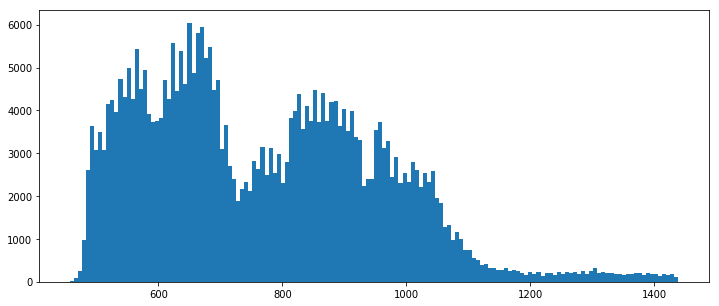

In [55]:
full_time['minutes'].hist(bins=150, figsize=(12, 5), grid=False);
# full_time['dt_std'].apply(np.log1p).hist(bins=150, figsize=(12, 5), grid=False);
# sns.distplot(full_time['minutes'], bins=150);

### get site features

In [71]:
text_cols = ['sites_num']
df_text = pd.DataFrame(columns=text_cols)
df_text['sites_num'] = full_sites.astype('str').apply(lambda x: ' '.join(x), axis=1)

for k in top_sites.keys():
    df_text[k] = full_sites.isin(top_sites[k]).sum(axis=1)

### pairs feat

In [72]:
pairs_tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=50000)
u_df = pairs_tfidf.fit_transform(df_users['data'])
s_df = pairs_tfidf.transform(df_text['sites_num'])
df_text['cosd'] = cosine_distances(s_df, u_df[0])
df_text['cos'] = cosine_similarity(s_df, u_df[0])
df_text['euc'] = euclidean_distances(s_df, u_df[0])
df_text['manh'] = manhattan_distances(s_df, u_df[0])

df_text['cosd'] = df_text['cosd'].apply(lambda x:np.power(x, 40))
df_text['cos'] = df_text['cos'].apply(lambda x:np.power(x, .2))
df_text['euc'] = df_text['euc'].apply(lambda x:np.power(x, 50))

### concat features

In [73]:
X_train = pd.concat([df_text.iloc[:idx_split], full_time.iloc[:idx_split]], axis=1)
X_test = pd.concat([df_text.iloc[idx_split:], full_time.iloc[idx_split:]], axis=1)

to_ignore = [2, 4]
mask = ~(X_train['total_months'].isin(to_ignore) & y_train==1)

X_train = X_train.loc[mask]
y_train = y_train.loc[mask]

X_train.tail(1)

,sites_num,top5,top10,top25,top50,top100,top250,top500,top1000,cosd,...,dow_4,dow_5,dow_6,h_12_13,h_16_17_18,h_not,dow_0_1,dow_2_3_4,dow_5_6,dow_not
session_id,,,,,,,,,,,,,,,,,,,,,
204762,222 3346 3346 3359 55 2891 3346 0 0 0,0,0,0,0,0,0,0,0,1.0,...,0,0,0,0,0,255,0,1,0,255


# Pipeline

In [24]:
def TSS(n_splits=10):
    time_split = TimeSeriesSplit(n_splits=10)
    myCViterator = list()
    i = 0
    for train_index, test_index in time_split.split(X_train):
        if i > 1:
            myCViterator.append((train_index, test_index))
        i += 1
    return myCViterator

In [25]:
# class ChooseColsDF(BaseEstimator):
#     """
#     Transformer to select a single column from the data frame to perform additional transformations on
#     Use on text columns in the data
#     """
#     def __init__(self, to_ignore):
#         self.to_ignore = to_ignore
        
#     def fit(self, X, y=None):
#         pass
    
#     def transform(self, X):
#         pass

#     def fit_transform(self, X, y=None):
#         if not self.to_ignore:
#             return X
#         mask = ~(X['total_months'].isin(self.to_ignore) & y==1)
#         return X.loc[mask], y.loc[mask]

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [39]:
pl_text_tfidf = Pipeline([
                ('select', TextSelector(key='sites_num')),
#                 ('tfidf', TfidfVectorizer(max_df=0.2, max_features=8000, smooth_idf=True, sublinear_tf=True)),
#                 ('tfidf', TfidfVectorizer(ngram_range=(1, 3), max_features=50000))
                ('tfidf', TfidfVectorizer(ngram_range=(1, 3), max_features=50000, 
                                          smooth_idf=True, binary=True, sublinear_tf=True))
#                     ('tfidf', TfidfVectorizer(ngram_range=(1, 3), max_features=30000, max_df=0.15))
                ])

pl_text_count = Pipeline([
                ('select', TextSelector(key='sites_num')),
                ('count', CountVectorizer(ngram_range=(1, 3), max_features=50000))
                ])

pl_time = Pipeline([
                ('select', NumberSelector(key=['4_spl0b', '4_spl1b', '4_spl2b']))
                ])

pl_time_scale = Pipeline([
                ('select', NumberSelector(key=['dow', 'dt'])),
                ('scale', StandardScaler())
#                 ('scale', MinMaxScaler())
                ])

pl_svd = Pipeline([
            ('select', TextSelector(key='sites_num')),
#             ('tfidf', TfidfVectorizer(ngram_range=(1, 3), max_features=50000, binary=True, sublinear_tf=True)),
            ('tfidf', TfidfVectorizer(ngram_range=(1, 3), max_features=50000, binary=True, sublinear_tf=True)),
            ('svd', TruncatedSVD(n_components=150, random_state=17))
            ])
# sklearn.decomposition.TruncatedSVD

feats = FeatureUnion([
                    ('pl_text', pl_text_tfidf), 
#                     ('pl_time', pl_time),
                    ('pl_time_scale', pl_time_scale)
                    ])


feats_ns = FeatureUnion([
                    ('pl_text', pl_text_tfidf), 
                    ('pl_time', pl_time),
#                     ('pl_time_scale', pl_time_scale)
                    ])

feats_all = FeatureUnion([
                    ('pl_text', pl_text_tfidf), 
                    ('pl_time', pl_time),
                    ('pl_time_scale', pl_time_scale),
#                     ('svd', pl_svd)
                    ])

pl = Pipeline([
                ('feats', feats),
                ('clf', LogisticRegression(C=3, random_state=17))
              ])

pl_ns = Pipeline([
                ('feats', feats_ns),
                ('clf', LogisticRegression(C=3, random_state=17))
              ])

pl_all = Pipeline([
                ('feats', feats_all),
                ('clf', LogisticRegression(C=3, random_state=17))
              ])

In [ ]:
[x for x in pl_all.get_params().keys() if 'h_' in x]

In [74]:
X_train.columns

Index(['sites_num', 'top5', 'top10', 'top25', 'top50', 'top100', 'top250',
       'top500', 'top1000', 'cosd', 'cos', 'euc', 'manh', 'total_months',
       'minutes', 'minutes_sin', 'minutes_cos', '4_spl0b', '4_spl1b',
       '4_spl2b', 'dow', 'dt', 'dt_std', 'h_7', 'h_8', 'h_9', 'h_10', 'h_11',
       'h_12', 'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18', 'h_19', 'h_20',
       'h_21', 'h_22', 'h_23', 'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4',
       'dow_5', 'dow_6', 'h_12_13', 'h_16_17_18', 'h_not', 'dow_0_1',
       'dow_2_3_4', 'dow_5_6', 'dow_not'],
      dtype='object')

In [88]:
np.logspace(-0.4, .8, 10)

array([0.39810717, 0.54116953, 0.73564225, 1.        , 1.35935639,
       1.8478498 , 2.51188643, 3.41454887, 4.64158883, 6.30957344])

In [90]:
%%time

params = {
#     'feats__svd__svd__n_components': [150],
#     'feats__svd__tfidf__ngram_range': [(1, 4)],
#     'feats__svd__tfidf__max_features': [20000],
#     'feats__svd__svd__random_state':[1, 5, 10, 15]
#     'feats__svd__tfidf__max_df': [.2, .5, .8]
    'clf__C': np.logspace(-0.4, .8, 10), #np.logspace(-0.1, 1, 10),  # np.logspace(-0.3, .7, 4),   # np.logspace(-1, 1, 6) 
#     'feats__pl_text__tfidf__max_df': [0.15],
#     'feats__pl_text__tfidf__min_df': np.logspace(-5, -1, 5),
#     'feats__pl_text__tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)]
#     'feats__pl_text__tfidf__max_features': [30000, 50000, 70000]# np.arange(10000, 100000, 20000)
#     'feats__pl_text__tfidf__smooth_idf': [True, False],
#     'feats__pl_text__tfidf__sublinear_tf': [True, False],
#     'feats__pl_text__tfidf__binary': [True, False]
    'feats__pl_time__select__key': [
#                                     ['h_12', 'h_13', 'h_16', 'h_17', 'h_18', 'h_not'],
#                                     ['h_12', 'h_13', 'h_16', 'h_17', 'h_18', 'h_not', 'dow_0_1'],
#                                     ['h_12', 'h_13', 'h_16', 'h_17', 'h_18', 'h_not', 'dow_0', 'dow_1', 'dow_not'],
#                                     ['h_12', 'h_13', 'h_16', 'h_17', 'h_18', 'dow_0', 'dow_1', 'dow_not'],
                                    ['h_12_13', 'h_16_17_18', 'h_not', 'dow_0_1'],
#                                     ['h_12_13', 'h_16_17_18', 'h_not', 'dow_0_1', 'dow_2_3_4', 'dow_5_6'],
                                   ]
#                                    ['month0', 'month1', 'month2', 'month3', '4_spl0b', '4_spl1b', '4_spl2b']],
#     'feats__pl_time_scale__select__key' : [
#                                            ['dow', 'dt', 'minutes'],
#                                            ['dow', 'dt', 'top10'],
#                                            ['dow', 'dt', 'top25'], 
#                                            ['dow', 'dt', 'cosd'], 
#                                            ['dow', 'dt', 'cos'], 
#                                            ['dow', 'dt', 'euc'], 
#                                            ['dow', 'dt', 'manh']
#                                             ],
        }

# ['top5', 'top10', 'top25', 'top50', 'top100', 'top250', 'top500', 'top1000']
# 'cosd', 'cos', 'euc', 'manh'

time_split = TSS(n_splits=10)

clf = GridSearchCV(pl_all, params, cv=time_split, verbose=1, scoring='roc_auc', n_jobs=-1)

clf.fit(X_train, y_train)

print(clf.best_params_, clf.best_score_)

Fitting 8 folds for each of 10 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  6.6min finished


{'clf__C': 4.641588833612781, 'feats__pl_time__select__key': ['h_12_13', 'h_16_17_18', 'h_not', 'dow_0_1']} 0.9519896968084572
CPU times: user 57.1 s, sys: 17.4 s, total: 1min 14s
Wall time: 7min 1s


{'feats__pl_time_scale__select__key': ['dow', 'dt', 'minutes']} 0.9570629687547612

In [ ]:
# LAST: 0.926157 +- 0.052944
# n_components=150  0.927681 +- 0.052297
# {'feats__svd__svd__n_components': 175, 'feats__svd__tfidf__max_features': 20000, 
#'feats__svd__tfidf__ngram_range': (1, 4)}   0.9283052 +- 0.051989

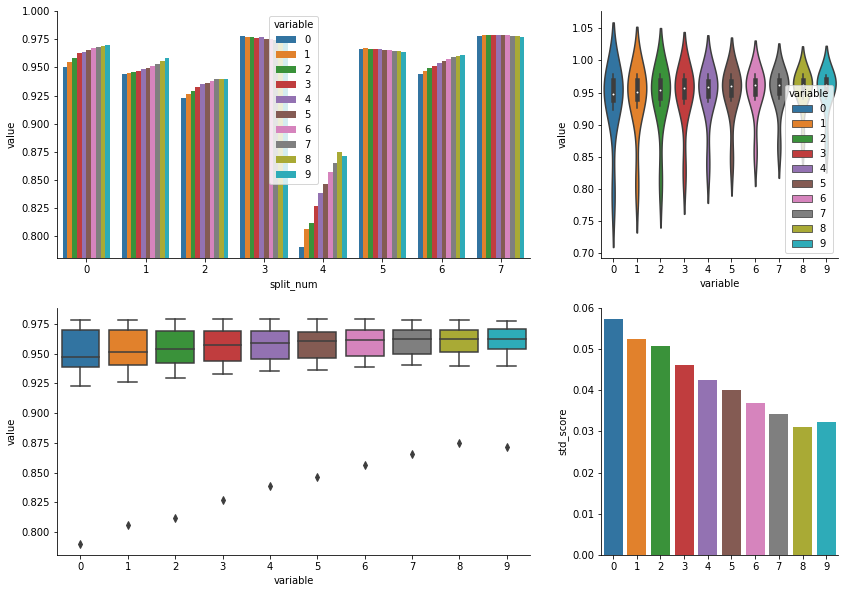

In [91]:
results, cv_results = analyze_results(clf.cv_results_)

In [92]:
# clf C
results#.sort_values('rank')

,clf__C,feats__pl_time__select__key,mean_score,std_score,rank
0,0.398107,"[h_12_13, h_16_17_18, h_not, dow_0_1]",0.934305,0.057193,10
1,0.541170,"[h_12_13, h_16_17_18, h_not, dow_0_1]",0.937865,0.052383,9
2,0.735642,"[h_12_13, h_16_17_18, h_not, dow_0_1]",0.939616,0.050760,8
3,1.000000,"[h_12_13, h_16_17_18, h_not, dow_0_1]",0.942780,0.046222,7
4,1.359356,"[h_12_13, h_16_17_18, h_not, dow_0_1]",0.945246,0.042578,6
5,1.847850,"[h_12_13, h_16_17_18, h_not, dow_0_1]",0.946738,0.040118,5
6,2.511886,"[h_12_13, h_16_17_18, h_not, dow_0_1]",0.948859,0.036910,4
7,3.414549,"[h_12_13, h_16_17_18, h_not, dow_0_1]",0.950431,0.034104,3
8,4.641589,"[h_12_13, h_16_17_18, h_not, dow_0_1]",0.951990,0.031073,1
9,6.309573,"[h_12_13, h_16_17_18, h_not, dow_0_1]",0.951772,0.032342,2


In [77]:
# clf C
results#.sort_values('rank')

,feats__pl_time__select__key,mean_score,std_score,rank
0,"[h_12, h_13, h_16, h_17, h_18, h_not]",0.951283,0.029398,1
1,"[h_12, h_13, h_16, h_17, h_18, h_not, dow_0_1]",0.949593,0.034305,3
2,"[h_12, h_13, h_16, h_17, h_18, h_not, dow_0, d...",0.946910,0.040146,5
3,"[h_12, h_13, h_16, h_17, h_18, dow_0, dow_1, d...",0.947743,0.038361,4
4,"[h_12_13, h_16_17_18, h_not, dow_0_1]",0.949798,0.035211,2
5,"[h_12_13, h_16_17_18, h_not, dow_0_1, dow_2_3_...",0.940225,0.037919,6


In [93]:
clf.refit

pred = clf.predict_proba(X_test)[:, 1]

write_to_submission_file(pred, 'preds/pred_0211_eda.csv')

#### PUBLIC SCORE 0.94730

`pl_text_tfidf = Pipeline([('select', TextSelector(key='sites_num')),
                ('tfidf', TfidfVectorizer(ngram_range=(1, 3), max_features=50000,   
                smooth_idf=True, binary=True, sublinear_tf=True))])`  
{'clf__C': 2.326305067153626} 0.9261085040325898  
rs = 17  
Index(['sites_num', 'morning', 'day', 'evening'], dtype='object')  